In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedchahed/glasses-detection-yolo-format")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\L\.cache\kagglehub\datasets\mohamedchahed\glasses-detection-yolo-format\versions\1


In [15]:
!pip install ultralytics kagglehub roboflow split-folders opencv-python matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil
import yaml
from ultralytics import YOLO
import kagglehub
import torch

In [17]:
def explore_directory_structure(path):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... and {len(files) - 5} more files')

explore_directory_structure(path)

1/
  data/
    child-children-girl-happy.jpg
    child-children-girl-happy.txt
    pexels-photo-10057618.jpeg
    pexels-photo-10057618.txt
    pexels-photo-10131170.jpeg
    ... and 263 more files


In [18]:
def find_files(directory, extensions):
    files = []
    for ext in extensions:
        files.extend([os.path.join(root, f)
                     for root, dirs, filenames in os.walk(directory)
                     for f in filenames if f.endswith(ext)])
    return files

# Find images and labels
image_files = find_files(path, ['.jpg', '.jpeg', '.png'])
label_files = find_files(path, ['.txt'])

print(f"Found {len(image_files)} images and {len(label_files)} label files")

Found 134 images and 134 label files


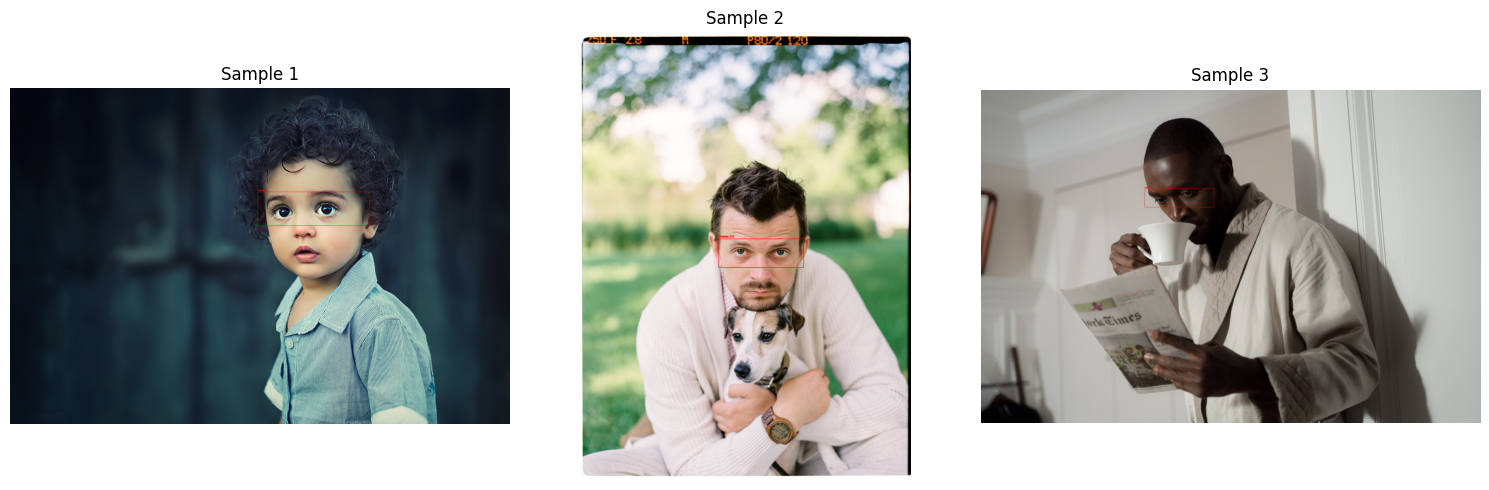

In [19]:
def plot_sample_images(image_paths, label_paths, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, (img_path, label_path) in enumerate(zip(image_paths[:num_samples], label_paths[:num_samples])):
        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read labels
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                data = line.strip().split()
                if len(data) == 5:  # YOLO format: class_id, x_center, y_center, width, height
                    class_id, x_center, y_center, bbox_w, bbox_h = map(float, data)

                    # Convert YOLO coordinates to pixel coordinates
                    x1 = int((x_center - bbox_w/2) * w)
                    y1 = int((y_center - bbox_h/2) * h)
                    x2 = int((x_center + bbox_w/2) * w)
                    y2 = int((y_center + bbox_h/2) * h)

                    # Draw bounding box
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, f'Glasses {class_id}', (x1, y1-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.show()

# Get sample files for visualization
sample_images = image_files[:3]
sample_labels = [os.path.join(os.path.dirname(img),
                             os.path.splitext(os.path.basename(img))[0] + '.txt')
                for img in sample_images]

plot_sample_images(sample_images, sample_labels)

In [20]:
dataset_dir = '/content/glasses_dataset'
os.makedirs(dataset_dir, exist_ok=True)

# Create directories
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dataset_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, split, 'labels'), exist_ok=True)

In [21]:
def prepare_dataset(image_paths, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Split the data
    train_images, temp_images = train_test_split(image_paths, train_size=train_ratio, random_state=42)
    val_images, test_images = train_test_split(temp_images, train_size=val_ratio/(val_ratio + test_ratio), random_state=42)

    return train_images, val_images, test_images

train_images, val_images, test_images = prepare_dataset(image_files)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

Training images: 93
Validation images: 27
Test images: 14


In [22]:
def copy_files(file_list, split_name):
    for img_path in file_list:
        # Get corresponding label path
        label_path = os.path.join(os.path.dirname(img_path),
                                 os.path.splitext(os.path.basename(img_path))[0] + '.txt')

        # Copy image
        dest_img = os.path.join(dataset_dir, split_name, 'images', os.path.basename(img_path))
        shutil.copy2(img_path, dest_img)

        # Copy label if exists
        if os.path.exists(label_path):
            dest_label = os.path.join(dataset_dir, split_name, 'labels', os.path.basename(label_path))
            shutil.copy2(label_path, dest_label)

# Copy files
copy_files(train_images, 'train')
copy_files(val_images, 'val')
copy_files(test_images, 'test')

print("Files copied successfully!")

Files copied successfully!


In [23]:
dataset_yaml = """
path: /content/glasses_dataset
train: train/images
val: val/images
test: test/images

names:
  0: glasses

nc: 1
"""

yaml_path = '/content/glasses_dataset/dataset.yaml'
with open(yaml_path, 'w') as f:
    f.write(dataset_yaml)

print("Dataset YAML file created!")

Dataset YAML file created!


In [24]:
model = YOLO('yolov8n.pt')

In [25]:
results = model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    patience=10,
    device='0' if torch.cuda.is_available() else 'cpu',
    project='glasses_detection',
    name='yolov8_glasses',
    verbose=True
)

Ultralytics 8.3.200  Python-3.12.10 torch-2.8.0+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/glasses_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_glasses, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, pe

In [26]:
metrics = model.val()
print("Validation results:")
print(f"mAP50-95: {metrics.box.map:.3f}")
print(f"mAP50: {metrics.box.map50:.3f}")
print(f"Precision: {metrics.box.mp:.3f}")
print(f"Recall: {metrics.box.mr:.3f}")

Ultralytics 8.3.200  Python-3.12.10 torch-2.8.0+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 3.22.9 ms, read: 96.424.0 MB/s, size: 10049.0 KB)
val: Scanning D:\content\glasses_dataset\val\labels.cache... 27 images, 0 backgrounds, 14 corrupt: 100% ━━━━━━━━━━━━ 27/27 13.4Kit/s 0.0s
val: D:\content\glasses_dataset\val\images\pexels-photo-11163628.jpeg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: D:\content\glasses_dataset\val\images\pexels-photo-14228164.jpeg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: D:\content\glasses_dataset\val\images\pexels-photo-14351048.jpeg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: D:\content\glasses_dataset\val\images\pexels-photo-14979219.jpeg: ig


image 1/1 C:\Users\L\.cache\kagglehub\datasets\mohamedchahed\glasses-detection-yolo-format\versions\1\data\pexels-photo-10619473.jpeg: 640x448 (no detections), 329.2ms
Speed: 6.1ms preprocess, 329.2ms inference, 30.7ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\L\.cache\kagglehub\datasets\mohamedchahed\glasses-detection-yolo-format\versions\1\data\pexels-photo-2446655.jpeg: 640x448 (no detections), 81.8ms
Speed: 4.1ms preprocess, 81.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\L\.cache\kagglehub\datasets\mohamedchahed\glasses-detection-yolo-format\versions\1\data\pexels-photo-709188.jpeg: 480x640 (no detections), 208.8ms
Speed: 7.4ms preprocess, 208.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


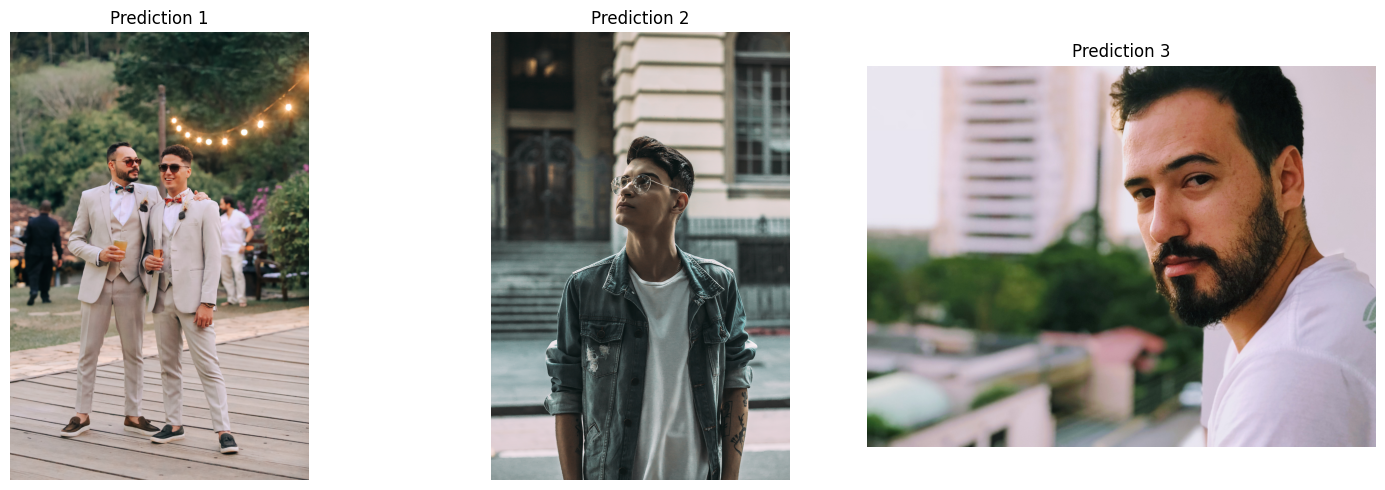

In [28]:
def test_model_on_samples(model, test_images, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, img_path in enumerate(test_images[:num_samples]):
        # Run prediction
        results = model(img_path)

        # Plot results
        for r in results:
            im_array = r.plot()
            im = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
            axes[i].imshow(im)
            axes[i].axis('off')
            axes[i].set_title(f'Prediction {i+1}')

    plt.tight_layout()
    plt.show()

test_model_on_samples(model, test_images)

In [29]:
model_path = '/content/glasses_detection_model.pt'
model.save(model_path)
print(f"Model saved to: {model_path}")

Model saved to: /content/glasses_detection_model.pt


In [30]:
onnx_path = model.export(format='onnx')
print(f"Model exported to ONNX: {onnx_path}")

Ultralytics 8.3.200  Python-3.12.10 torch-2.8.0+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'D:\NTI IB\object detection\glasses_detection\yolov8_glasses\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.67', 'onnxruntime'] not found, attempting AutoUpdate...
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
    --------------------------------------- 0.3/16.5 MB ? eta -:--:--
    --------------------------------------- 0.3/16.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/16.5 MB 728.2 kB/s eta 0:00:22
   - -------------------------------------- 0.5/16.5 MB 728.2 kB/s eta 0:00:22
   - ------

In [31]:
def detect_glasses(image_path, model_path=model_path):
    """
    Detect glasses in an image using the trained model
    """
    model = YOLO(model_path)
    results = model(image_path)

    # Process results
    detections = []
    for result in results:
        boxes = result.boxes
        if boxes is not None:
            for box in boxes:
                confidence = box.conf.item()
                class_id = int(box.cls.item())
                bbox = box.xyxy[0].tolist()
                detections.append({
                    'class': 'glasses',
                    'confidence': confidence,
                    'bbox': bbox
                })

    return detections, results


image 1/1 C:\Users\L\.cache\kagglehub\datasets\mohamedchahed\glasses-detection-yolo-format\versions\1\data\pexels-photo-10619473.jpeg: 640x448 (no detections), 151.1ms
Speed: 5.8ms preprocess, 151.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)
Detections in sample image:


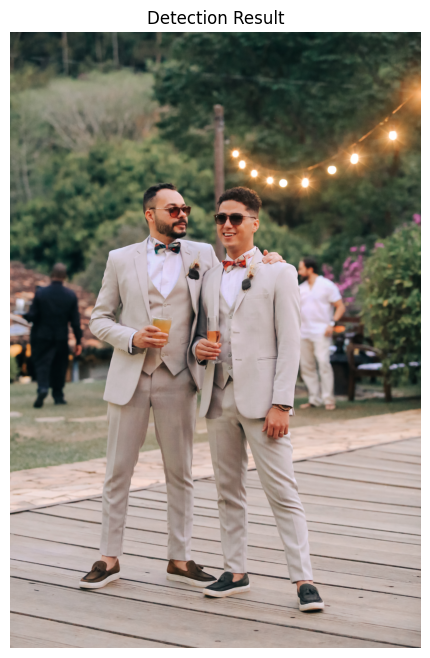

In [32]:
sample_test_image = test_images[0]
detections, results = detect_glasses(sample_test_image)

print(f"Detections in sample image:")
for i, detection in enumerate(detections):
    print(f"Detection {i+1}: {detection}")

# Display the result
result = results[0]
im_array = result.plot()
im = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 8))
plt.imshow(im)
plt.axis('off')
plt.title('Detection Result')
plt.show()

In [33]:
import json

training_results = {
    'model_path': model_path,
    'dataset_size': {
        'train': len(train_images),
        'val': len(val_images),
        'test': len(test_images)
    },
    'metrics': {
        'mAP50-95': metrics.box.map,
        'mAP50': metrics.box.map50,
        'precision': metrics.box.mp,
        'recall': metrics.box.mr
    }
}

with open('/content/training_results.json', 'w') as f:
    json.dump(training_results, f, indent=4)

print("Training results saved!")

Training results saved!


In [34]:
print("YOLO glasses detection model training completed successfully!")

YOLO glasses detection model training completed successfully!
